# Chapt 15.8 Pretraining BERT

In [ ]:
!pip install setuptools==66
!pip install matplotlib_inline
!pip install d2l==1.0.0b

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def get_tokens_and_segments(tokens_a, tokens_b = None):
  tokens = ['<cls>'] + tokens_a + ['<sep>']
  segments = [0] * (len(tokens_a) + 2)
  # if token_b none: --> (<cls> <token1> ... <sep>) 
  if tokens_b is not None:
    # if token_b not none: --> (<cls> <tokena> ... <sep> <tokenb> ... <sep>) 
    tokens += tokens_b + ['<sep>']
    segments += [1] * (len(tokens_b) + 1)
  #segments = [0,0,0,...,1,1,1] if token b is not none
  #else = [0,0,0...]
  return tokens, segments

In [ ]:
class BERTEncoder(nn.Module):
  #Bert Encoder
  def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, max_len = 1000, **kwargs):
    super(BERTEncoder, self).__init__(**kwargs)
    self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
    self.segment_embedding = nn.Embedding(2, num_hiddens)
    self.blks = nn.Sequential()
    for i in range(num_blks):
      self.blks.add_module(f'{i}', d2l.TransformerEncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
    
    #In BERT, positional embedding is learnable 
    #so we create a positional embedding that is long enough
    self.pos_embedding = nn.Parameter(torch.randn(1,max_len, num_hiddens))

  def forward(self, tokens, segments, valid_lens):
    #X shape = (batch_size, max_sequence_length, num_hiddens)
    X = self.token_embedding(tokens) + self.segment_embedding(segments)
    X = X + self.pos_embedding[:, :X.shape[1],:]
    for block in self.blks:
      X = block(X, valid_lens)
    return X


#Test run
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blocks, dropout = 768, 2, 0.2

encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blocks, dropout) 

tokens = torch.randint(0, vocab_size, (2,8))
print('tokens shape = ',tokens.shape)

segments = torch.tensor([[0,0,0,0,0,1,1,1], [0,0,0,1,1,1,1,1]])
print('segments shape = ',segments.shape)

encoded_X = encoder(tokens, segments, None)
#X shape = (batch_size, max_sequence_length, num_hiddens)
print("X shape = ", encoded_X.shape)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tokens shape =  torch.Size([2, 8])
segments shape =  torch.Size([2, 8])
X shape =  torch.Size([2, 8, 768])


In [ ]:
# this is to perform masked language model prediction
class MaskLM(nn.Module):
  def __init__(self, vocab_size, num_hiddnes, **kwargs):
    super(MaskLM, self).__init__(**kwargs)
    self.mlp = nn.Sequential(
        nn.LazyLinear(num_hiddens),
        nn.ReLU(),
        nn.LayerNorm(num_hiddens),
        nn.LazyLinear(vocab_size)
    )
  
  def forward(self, X, pred_positions):
    num_pred_positions = pred_positions.shape[1]
    #flatten the pred positions
    pred_positions = pred_positions.reshape(-1)
    #batch_size
    batch_size = X.shape[0]
    #batch idx
    batch_idx = torch.arange(0, batch_size)
    #repeat interleave, ex: a = [0,1,3], 
    #repeat_interleave(a, 3) --> [0,0,0,1,1,1,3,3,3]
    batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
    masked_X = X[batch_idx, pred_positions]
    masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
    mlm_Y_hat = self.mlp(masked_X)

    return mlm_Y_hat
  
#Example
#vocab_size = 10000, num_hiddens = 768
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1,5,2], [6,1,5]])

tokens = torch.randint(0, vocab_size, (2,8))
print('tokens = ', tokens)
segments = torch.tensor([[0,0,0,0,0,1,1,1], [0,0,0,1,1,1,1,1]])
encoded_X = encoder(tokens, segments, None)
#X shape = (batch_size, max_sequence_length, num_hiddens)
print("X shape = ", encoded_X.shape)

mlm_Y_hat = mlm(encoded_X, mlm_positions)
print('mlm Y hat shape = ', mlm_Y_hat.shape)

#Loss Function for Masked Language Model
#ground truth
mlm_Y = torch.tensor([[7,8,9], [10,20,30]])
loss = nn.CrossEntropyLoss(reduction = 'none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))

print('mlm loss = ', mlm_l)
print('mlm loss shape =', mlm_l.shape)

tokens =  tensor([[1245, 1532, 8084, 4250, 7013, 5033, 1892, 1576],
        [5567,  701, 2602, 4155, 6758, 9681, 8485, 7511]])
X shape =  torch.Size([2, 8, 768])
mlm Y hat shape =  torch.Size([2, 3, 10000])
mlm loss =  tensor([8.3684, 9.7138, 8.4931, 9.0963, 9.0097, 8.7351],
       grad_fn=<NllLossBackward0>)
mlm loss shape = torch.Size([6])


In [ ]:
#Next Sentence Prediction
class NextSentencePred(nn.Module):
  def __init__(self, **kwargs):
    super(NextSentencePred, self).__init__(**kwargs)
    self.output = nn.LazyLinear(2)
  
  def forward(self, X):
    #X shape (batch_size, # hiddens)
    return self.output(X)

#Test run
encoded_X = torch.flatten(encoded_X, start_dim = 1)
#input shape for NSP: (batch_size, # hiddens)

nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)

print('NSP hat shape = ', nsp_Y_hat.shape)

nsp_y = torch.tensor([0,1])
nsp_l = loss(nsp_Y_hat, nsp_y)


print('NSP loss', nsp_l)
print('NSP loss shape ', nsp_l.shape)

NSP hat shape =  torch.Size([2, 2])
NSP loss tensor([1.4976, 0.3781], grad_fn=<NllLossBackward0>)
NSP loss shape  torch.Size([2])


In [ ]:
class BERTModel(nn.Module):
  #BERT model

  def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, 
               num_heads, num_blks, dropout, max_len = 1000):
    super(BERTModel, self).__init__()
    self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, 
                               num_heads, num_blks, dropout, max_len = max_len)
    self.hidden = nn.Sequential(
        nn.LazyLinear(num_hiddens), 
        nn.Tanh()
        ) 
    self.mlm = MaskLM(vocab_size, num_hiddens)
    self.nsp = NextSentencePred()
  
  def forward(self, tokens, segments, valid_lens = None, pred_positions = None):
    encoded_X = self.encoder(tokens, segments, valid_lens)

    if pred_positions is not None:
      mlm_Y_hat = self.mlm(encoded_X, pred_positions)
    else:
      mlm_Y_hat = None
    
    #0 is the index of <cls> token
    nsl_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))

    return encoded_X, mlm_Y_hat, nsp_Y_hat


# Chapt 15.10 Pretraining BERT

In [ ]:
#@title Training params
batch_size = 512 #@param {type:"number"}
max_len = 64 #@param {type:"number"}
num_hiddens = 128 #@param {type:"number"}
ffn_num_hiddens = 256 #@param {type:"number"}
num_heads = 2 #@param {type:"number"}
num_blks = 2 #@param {type:"number"}
dropout = 0.2 #@param {type:"number"}

In [ ]:
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)
net = d2l.BERTModel(len(vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)

devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
# def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, 
#                          segments_X, valid_lens_x,
#                          pred_positions_X, mlm_weights_X,
#                          mlm_Y, nsp_y
#                          ):
#   #forward pass to BERT encoder 
#   _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, 
#                                 segments_X, 
#                                 valid_lens_x.reshape(-1), 
#                                 pred_positions_X)

#   #compute mlm loss
#   mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) \
#   * mlm_weights_X.reshape(-1, 1)

#   mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)

#   #compute next sentence pred loss
#   nsp_l = loss(nsp_Y_hat, nsp_y)
#   l = mlm_l + nsp_l

#   return mlm_l, nsp_l, l

def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

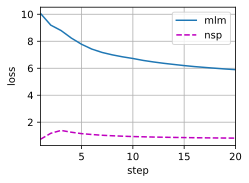

In [ ]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
  net(*next(iter(train_iter))[:4])

  net = nn.DataParallel(net, device_ids = devices).to(devices[0])
  trainer = torch.optim.Adam(net.parameters(), lr = 0.01)

  step, timer = 0, d2l.Timer()

  animator = d2l.Animator(xlabel = 'step', ylabel = 'loss', xlim = [1, num_steps], legend = ['mlm', 'nsp'])

  #sum of mlm losses, sum of nsp losses, # of sentences pairs, count 
  metric = d2l.Accumulator(4)

  num_steps_reached = False

  while step < num_steps and not num_steps_reached:
    # for tokens_X, segments_X, valid_lens_x, pred_positions_X, \
    #     mlm_weights_X, mlm_Y, nsp_y in train_iter:
    for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
      mlm_weights_X, mlm_Y, nsp_y in train_iter:
      tokens_X = tokens_X.to(devices[0])
      segments_X = segments_X.to(devices[0])
      valid_lens_x = valid_lens_x.to(devices[0])
      pred_positions_X = pred_positions_X.to(devices[0])
      mlm_weights_X = mlm_weights_X.to(devices[0])
      mlm_Y = mlm_Y.to(devices[0])
      nsp_y = nsp_y.to(devices[0])
      
      trainer.zero_grad()
      timer.start()

      mlm_l, nsp_l, l = _get_batch_loss_bert(
          net, loss, vocab_size, tokens_X, segments_X, valid_lens_x, 
          pred_positions_X, mlm_weights_X, mlm_Y, nsp_y
      )

      l.backward()

      trainer.step()

      metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)

      timer.stop()

      animator.add(step + 1, (metric[0] / metric[3], metric[1] / metric[3]))

      step += 1

      if step == num_steps:
        num_steps_reached = True
        break
      
      print(f'MLM loss {metric[0] / metric[3]:.3f}, '
        f'NSP loss {metric[1] / metric[3]:.3f}')
      print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
            f'{str(devices)}')

num_steps = 20
train_bert(train_iter, net, loss, len(vocab), devices, num_steps)






In [ ]:
def get_bert_encoding(net ,tokens_a, tokens_b = None, debug = False):
  tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
  tokens_id = torch.tensor(vocab[tokens], device = devices[0]).unsqueeze(0)
  segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
  valid_len = torch.tensor(len(tokens), device = devices[0]).unsqueeze(0)
  if debug:
    print('segments shape = ', segments.shape)
    print('token id shape = ', tokens_id.shape)
    print('valid_lens shape = ', valid_len.shape)
  encoded_X, _, _ = net(tokens_id, segments, valid_len)

  return encoded_X

tokens_a = 'a crane is flying'.split(' ')
#len = len(tokens_a) + 2 (1 for <cls>, 1 for <sep>)
encoded_text = get_bert_encoding(net, tokens_a, None, True)

# encoded_text shape (batch_size, sequencel len, # hiddens)
print('encoded_text shape = ', encoded_text.shape)

#encoded token for cls 
encoded_text_cls = encoded_text[:, 0, :]
print('encoded_text_cls shape = ', encoded_text_cls.shape)

#encoded token for 'crane'
encoded_text_crane = encoded_text[:, 2, :]
print('encoded_text_crane shape = ', encoded_text_crane.shape)

segments shape =  torch.Size([1, 6])
token id shape =  torch.Size([1, 6])
valid_lens shape =  torch.Size([1])
encoded_text shape =  torch.Size([1, 6, 128])
encoded_text_cls shape =  torch.Size([1, 128])
encoded_text_crane shape =  torch.Size([1, 128])


In [ ]:
# text pair
tokens_a = 'a crane driver came'.split(" ")
tokens_b = 'he just left'.split(" ")

encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
print('encoded_pair shape = ', encoded_pair.shape)

encoded_pair_cls = encoded_pair[:, 0, :]
print('encoded_pair_cls shape = ', encoded_pair_cls.shape)
encoded_pair_crane = encoded_pair[:, 2, :]
print('encoded_pair_crane shape = ', encoded_pair_crane.shape)

encoded_pair shape =  torch.Size([1, 10, 128])
encoded_pair_cls shape =  torch.Size([1, 128])
encoded_pair_crane shape =  torch.Size([1, 128])
